<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

***ЗАДАЧА***

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



***ПЛАН РАБОТЫ***

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
# !pip install catboost
# !pip install lightgbm
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import timeit
import datetime
import calendar

pd.set_option('display.max_colwidth', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RAST = 99

Загрузим данные

In [2]:
try:  
    hour_order = pd.read_csv('/datasets/taxi.csv')
except:
    hour_order = pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\11_taxi.csv')

Выведем обчую информацию

In [3]:
hour_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В нашей таблице содержится 26496 наблюдений, 1 признак и один целевой признак. Признак содержит в себе значение даты и времени на временной оси, а цлевой признак - число заказов в конкретный временной промежуток. Пропуски отсутствуют. Посмотрим на первые и последнии 5 строк

In [4]:
display(hour_order.head())
display(hour_order.tail())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


В наших данных интервал равен 10 минутам. По заданию необходимо увеличить его до 1 часа. Но для начала изменим тип данных у признака на временной.

In [5]:
hour_order.datetime = hour_order.datetime.astype('datetime64[ns]')

Изучим основные статистические показатели целевого признака

In [6]:
display(hour_order.describe().T)

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


В нашей выборке максимальное количество заказанных такси в интервале в 10 минут равняется 119 шт., а минимальное - 0.

Проверим наличие дубликатов по столбцу "datetime"

In [7]:
print(f'Количество дубликатов: {hour_order.datetime.duplicated().sum()}')

Количество дубликатов: 0


Проверим, в хронологическом ли порядке расположены даты и время

In [8]:
display(hour_order.datetime.is_monotonic)

True

Проверим, все ли интервалы равны 10 минутам

In [9]:
print(f'Количество интервалов, не равное 10 минутам: {len(hour_order[hour_order["datetime"].diff() != pd.Timedelta("10m")])}')

Количество интервалов, не равное 10 минутам: 1


Все в порядке. Один интервал не сходится так это интервал между первой строкой и отсутствующей предыдущей. Остальные интервалы ровно по 10 минут

Установим индекс таблицы равный столбцу "datetime"

In [10]:
hour_order.set_index('datetime', inplace=True)

Порядок соблюден, дубликаты отсутствуют, интервал соблюден. У нас в распоряжении выборка в период с 1 марта 2018 г. по 31 августа 2018 г. включительно.

Изменим интервал временного ряда с 10 минут на 1 час. Количество заказов такси просуммируем. Выполним ресемплирование

In [11]:
hour_order = hour_order.resample('1H').sum()

Снова выведем основные статистические показатели

In [12]:
display(hour_order.describe().T)

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


У нас все еще имеются временные интервалы с нулевым количеством заказов такси. Изменим тип данных столбца "num_orders" на "uint16"

In [13]:
hour_order = hour_order.astype('uint16')

## Анализ

Изучим часы, когда заказов такси небыло

In [14]:
display(hour_order.query('num_orders == 0'))

,num_orders
datetime,
2018-04-06 06:00:00,0


За пол года всего один час, когда небыло заказов. Такое более чем возможно.

Подготовим функцию для вывода графиков временных рядов

In [15]:
def time_series(df, ttl, xl, yl, day_week):
    sns.set(style='darkgrid')
    plt.figure(figsize=(16, 3))
    ax = sns.lineplot(data=df , palette='Set1', linewidth=1)
    if day_week:
        date_form = DateFormatter('%A')
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.title(ttl)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

Выведем почасовой график заказов такси за весь период

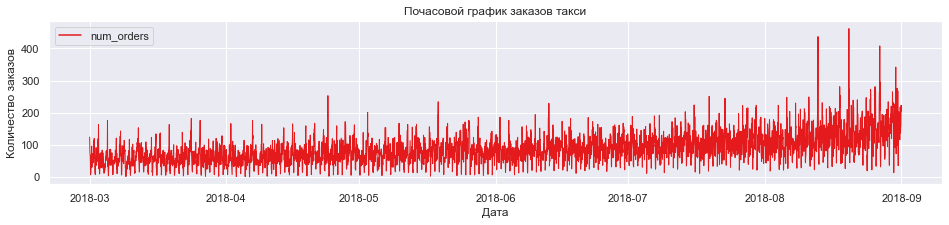

In [16]:
time_series(hour_order, 'Почасовой график заказов такси', 'Дата', 'Количество заказов', False)

Все слипается, по такому графику мы не сделаем выводов. Выведем график скользящего среднего с окном равным 168 и скользящее стандартное отклонение с тем же окном

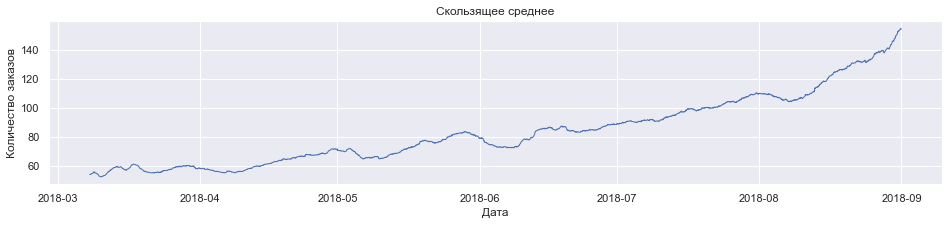

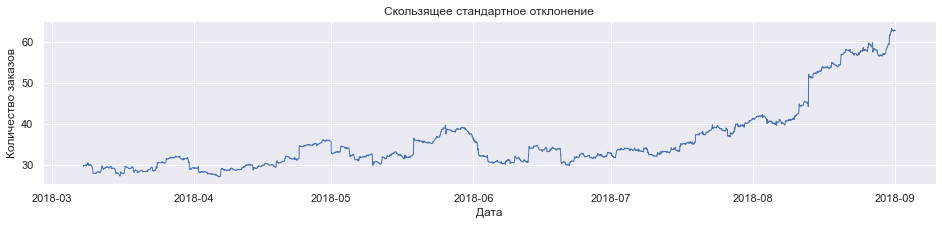

In [17]:
time_series(hour_order['num_orders'].rolling(168).mean(), 'Скользящее среднее', 'Дата', 'Количество заказов', False)
time_series(hour_order['num_orders'].rolling(168).std(),\
            'Скользящее стандартное отклонение', 'Дата', 'Количество заказов', False)

Видим на обоих графиках что среднее значение и стандартное отклонение со временем изменяются, а значит стохастический процесс времянного ряда нестационарный. Также стоит отметить, что с марта по июль количество заказов такси увеличивается плавно, но увеличение заказов в августе отлично от остальных месяцев, рост более резкий. Кроме того наблюдается заметный спад заказов в начале большенства месяцев.

Выведем графики сезонности, тренда и шумов

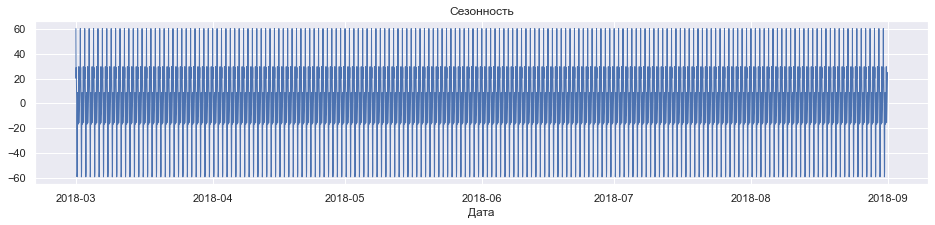

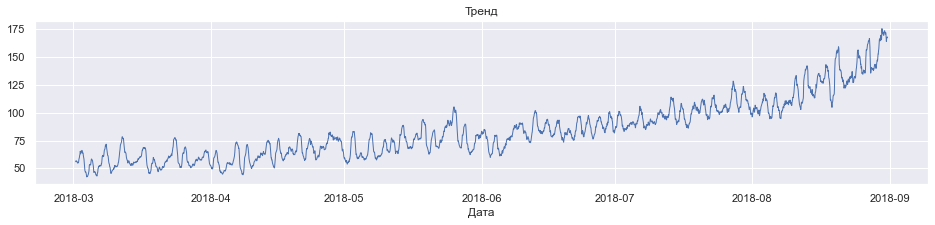

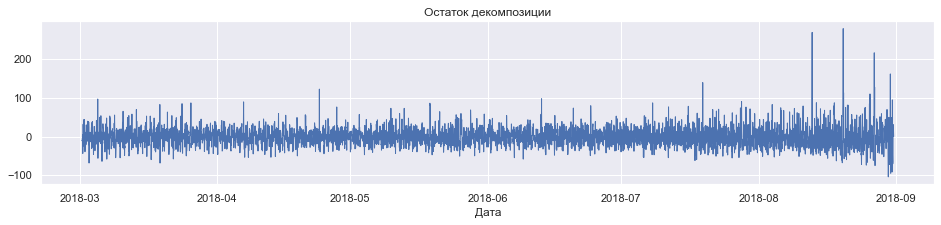

In [18]:
time_series(seasonal_decompose(hour_order).seasonal, 'Сезонность', 'Дата', '', False)
time_series(seasonal_decompose(hour_order).trend, 'Тренд', 'Дата', '', False)
time_series(seasonal_decompose(hour_order).resid, 'Остаток декомпозиции', 'Дата', '', False)

С трендом вроде все понятно, мы наблюдаем постонное увеличение заказов, возможно это следствие увеличения клиентской базы. Сезонность проанализировать невозможно, необходим изменять масштаб. В шумах заметны отдельные всплески как внутри каждого месяца так и в августе по сравнению с остальными месяцами. Изучим поподробнее шумы в августе

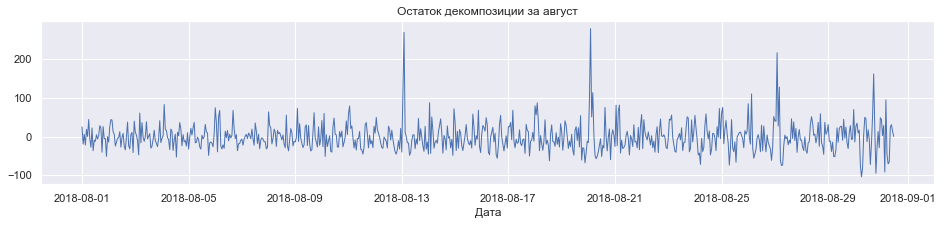

In [19]:
time_series(seasonal_decompose(hour_order).resid['2018-08-01':'2018-08-31'],\
            'Остаток декомпозиции за август', 'Дата', '', False)

Напишем функцию вывода наименования дня недели по дате

In [20]:
def day_of_the_week(year, month, day):
    return calendar.day_abbr[datetime.date(year, month, day).weekday()]

В августе у нас имеется четыре сильных всплеска по шумам, узнаем что это за дни недели

In [21]:
print(day_of_the_week(2018, 8, 13), day_of_the_week(2018, 8, 20), day_of_the_week(2018, 8, 27), day_of_the_week(2018, 8, 31))

Mon Mon Mon Fri


Очень странные шумы... В первый понедельник месяца все также как и в остальные дни, но остальные понедельники имеют сильный шум.

Изучим более приближенно сезонность по двум месяцам

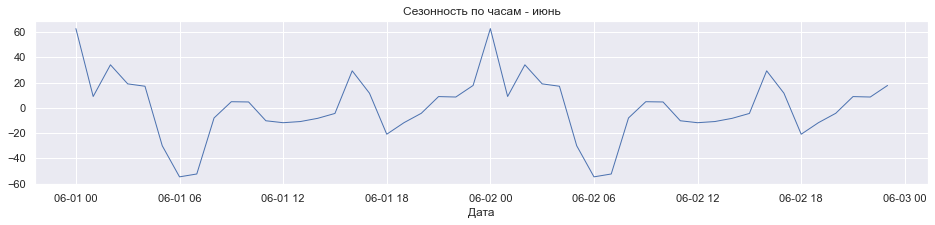

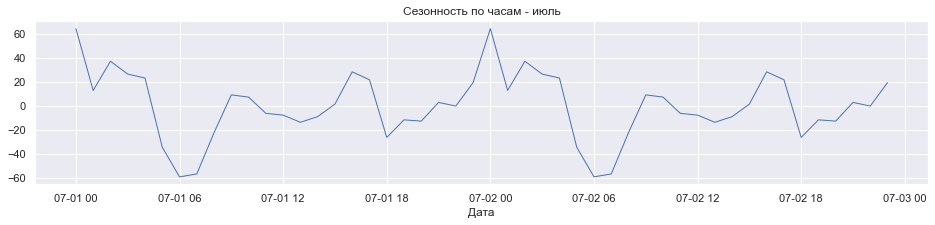

In [22]:
time_series(seasonal_decompose(hour_order['2018-06']).seasonal['2018-06-01':'2018-06-02'],\
            'Сезонность по часам - июнь', 'Дата', '', False)
time_series(seasonal_decompose(hour_order['2018-07']).seasonal['2018-07-01':'2018-07-02'],\
            'Сезонность по часам - июль', 'Дата', '', False)

Мы наблюдаем циклично повторяющиеся закономерности. Наибольшее количество заказов приходится на ночное время суток - примерно с 11 вечера до 4 утра, видимо это следствие отсутствия в это время суток общественного транспорта, c 9 до 11 утра - на начало рабочего дня (странно что не с 7-8 устра), а так же на промежуток с 16 часов до 18-ти - под конец рабочего дня . Наименьшее же количество заказов приходится на 6 утра (как мы ранее заметили оно даже достигает 0).

Изучим сезонность по дням недели. Выберем по одной неделе каждого месяца для сравнения.

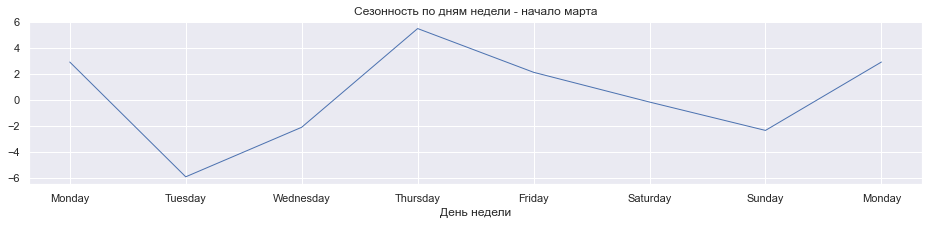

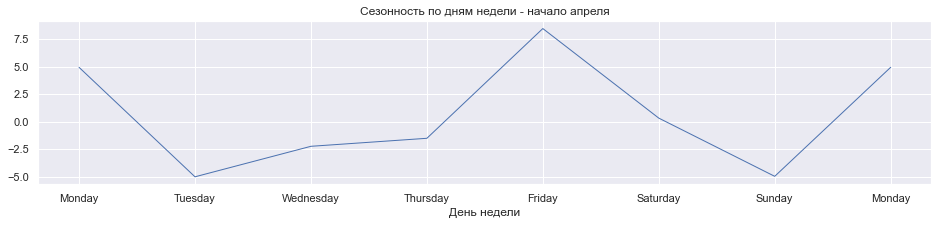

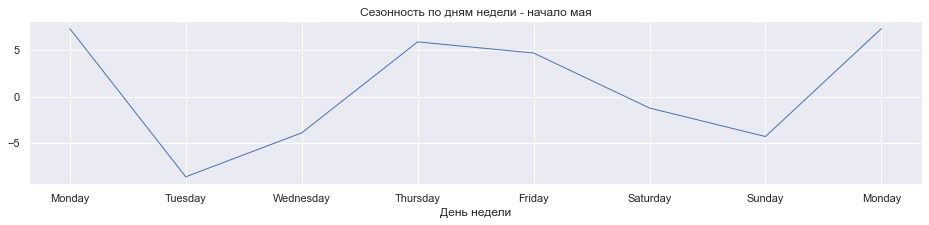

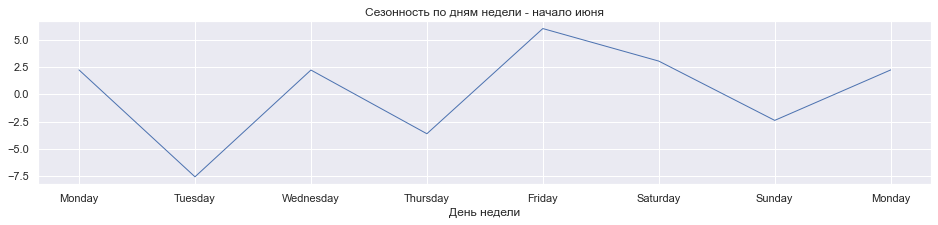

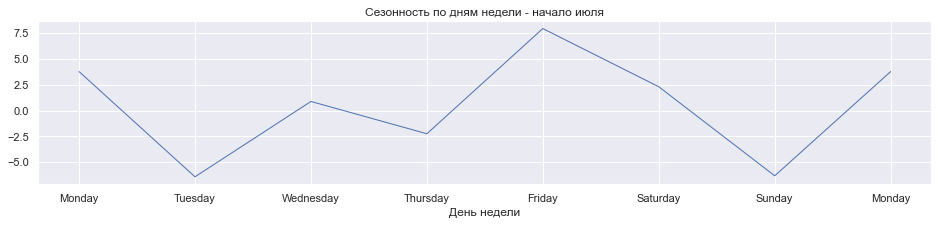

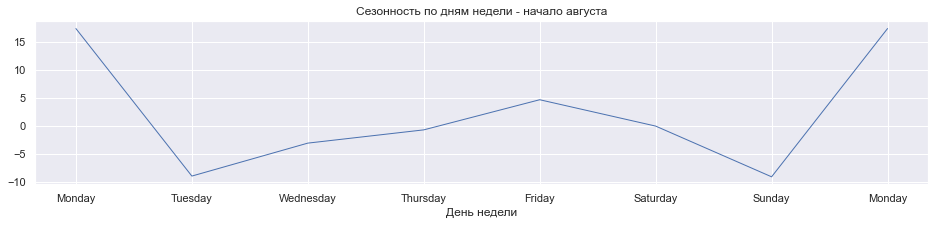

In [23]:
time_series(seasonal_decompose(hour_order['2018-03'].resample('1D').mean()).seasonal['2018-03-05':'2018-03-12'],\
            'Сезонность по дням недели - начало марта', 'День недели', '', True)
time_series(seasonal_decompose(hour_order['2018-04'].resample('1D').mean()).seasonal['2018-04-02':'2018-04-09'],\
            'Сезонность по дням недели - начало апреля', 'День недели', '', True)
time_series(seasonal_decompose(hour_order['2018-05'].resample('1D').mean()).seasonal['2018-05-07':'2018-05-14'],\
            'Сезонность по дням недели - начало мая', 'День недели', '', True)
time_series(seasonal_decompose(hour_order['2018-06'].resample('1D').mean()).seasonal['2018-06-04':'2018-06-11'],\
            'Сезонность по дням недели - начало июня', 'День недели', '', True)
time_series(seasonal_decompose(hour_order['2018-07'].resample('1D').mean()).seasonal['2018-07-02':'2018-07-09'],\
            'Сезонность по дням недели - начало июля', 'День недели', '', True)
time_series(seasonal_decompose(hour_order['2018-08'].resample('1D').mean()).seasonal['2018-08-06':'2018-08-13'],\
            'Сезонность по дням недели - начало августа', 'День недели', '', True)

По каждому из 6 месяцев сезонность различная. Из общего можно отметить что вторник и воскресенье всегда наименее популярные дни для заказа такси, а понедельник и пятница - наиболее загруженные дни по количеству заказов. Так же стоит отметить март и май - в эти месяцы сильно загружен четверг, а по понедельникам в августе заказы в разы превышают остальные дни. Приступим к обучению моделей.

## Обучение

Для начала выведем значение RMSE, которое в дальнейшем будем сравнивать с RMSE моделей для проверки на адекватность, путем сравнения текущего количества заказов с предыдущим по ряду

In [24]:
train_adequacy, test_adequacy = train_test_split(hour_order, shuffle=False, test_size=0.1)
print('RMSE по предыдущему значению ряда: {:.2f}'\
      .format(mean_squared_error(pd.DataFrame(index=test_adequacy.index, data=hour_order.shift()), test_adequacy) ** 0.5))

RMSE по предыдущему значению ряда: 58.86


Добавим в данные 4 календарно-временных признака - месяц, день, день недели и час заказа. Подберем максимальное количество отставаний от целевого признака и добавим отстающие признаки, количество которых будет равно значению максимального отставания, а значение каждого нового признака будет равно предыдущему значению признака с часовым шагом назад по времени. Так же подберем ширину окна и добавим последний признак - скользящее среднее по целевому признаку без учета текущего значения. В итоге у нас получится чуть меньшее количество наблюдений из за появившихся пропусков - строки с пропусками мы удалим.

In [25]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'], df['day'] = df.index.month, df.index.day
    df['dayofweek'], df['hour'] = df.index.dayofweek, df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_' + str(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['lag_1'].rolling(rolling_mean_size).mean()
    df.dropna(inplace=True)
    
    

make_features(hour_order, 150, 10)

Разделим данные на обучающую и тестовую выборки в соотношении 9:1, а после на признаки и целевой признак.

In [26]:
X = hour_order.drop('num_orders', axis=1)
y = hour_order.num_orders
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

Сохраним в переменную шапку таблицы, в которую постепенно будем сохранять результаты обучения и тестированияю

In [27]:
all_result = pd.DataFrame(columns=['Модель', 'Оптимальные параметры',\
                                   'RMSE кросс-валидация', 'Время обучения, сек.', 'RMSE тест', 'Время предсказания, сек.'])

Напишем функцию, которая:
- На вход получит обучающую выборку, разделенную на признаки и целевой признак, обучаемую модель и ее гиперпараметры для перебора
- Пропустит через кросс-валидатор GridSearchCV нашу выборку, попутно масштабируя признаки, разделяя их на 2 фолда без нарушения последовательности времени (при помощи TimeSeriesSplit) и перебирая гиперпараметры.
- Вернет таблицу с информацией о наименовании модели, наилучшими подобранными параметрами, среднее RMSE по результатам кросс-валидации и время обучения модели.
- В отдельную переменную сохранит обученную модель

In [28]:
def my_pipe(X_tr, y_tr, regressor, regressor_name, params, results):
        scaler = StandardScaler()
        steps = [('normalizer', scaler), ('regressor', regressor)]
        pipe = Pipeline(steps)
    
        tss_cv = TimeSeriesSplit(n_splits=2)

        time_start_fit = timeit.default_timer()
        grid_search = GridSearchCV(pipe, params, cv=tss_cv, scoring='neg_mean_squared_error',\
                                   n_jobs = -1, verbose = 0, pre_dispatch='2 * n_jobs')
        grid_search.fit(X_tr, y_tr)
        time_fit = timeit.default_timer() - time_start_fit
        score = round((-grid_search.best_score_) ** 0.5, 4)
            
            
        result = pd.DataFrame(data=[[regressor_name, grid_search.best_params_, score,\
                                     round(time_fit, 4), None, None]],\
                              columns=['Модель', 'Оптимальные параметры','RMSE кросс-валидация',\
                                       'Время обучения, сек.', 'RMSE тест', 'Время предсказания, сек.'])
    
        display(result)
        return results.append(result, ignore_index=True), grid_search.best_estimator_

При помощи функции обучим 5 различных моделей с подбором наилучших гиперпараметров ***(сам процесс подбора гиперпараметров не включен в проект ввиду крайне длительного по времени перебора параметров для некоторых моделей, модели будут обучатся уже на оптимальных гиперпараметрах)***

In [29]:
all_result, lin_reg = my_pipe(X_train, y_train, LinearRegression(), 'LinearRegression', {}, all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,LinearRegression,{},25.3461,2.2195,None,None


In [30]:
all_result, lasso = my_pipe(X_train, y_train, Lasso(random_state=RAST), 'Lasso Regression',\
                            {'regressor__alpha': [0.4],'regressor__max_iter': [500]}, all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,Lasso Regression,"{'regressor__alpha': 0.4, 'regressor__max_iter': 500}",24.4078,1.5952,None,None


In [31]:
all_result, tree = my_pipe(X_train, y_train, DecisionTreeRegressor(random_state=RAST), 'DecisionTreeRegressor',\
                           {'regressor__max_depth': [6], 'regressor__min_samples_split': [5],\
                            'regressor__min_samples_leaf': [18]}, all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,DecisionTreeRegressor,"{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 18, 'regressor__min_samples_split': 5}",30.1192,1.8492,None,None


In [32]:
all_result, cat_boost = my_pipe(X_train, y_train, CatBoostRegressor(random_state=RAST, verbose=0), 'CatBoostRegressor',\
                                {'regressor__iterations': [1600], 'regressor__depth': [6],\
                                 'regressor__learning_rate': [0.01], 'regressor__loss_function': ['RMSE'],\
                                 'regressor__leaf_estimation_iterations':[6]}, all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations': 1600, 'regressor__leaf_estimation_iterations': 6, 'regressor__learning_rate': 0.01, 'regressor__loss_function': 'RMSE'}",24.93,71.0261,None,None


In [33]:
all_result, lgbm = my_pipe(X_train, y_train, LGBMRegressor(random_state=RAST, verbose=0, force_col_wise = True),\
                           'LGBMRegressor', {'regressor__max_depth': [12],'regressor__num_leaves': [17],\
                                             'regressor__min_child_samples':[10]}, all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,LGBMRegressor,"{'regressor__max_depth': 12, 'regressor__min_child_samples': 10, 'regressor__num_leaves': 17}",25.4962,2.4002,None,None


Изучим финальный результат обучения

In [34]:
display(all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,LinearRegression,{},25.3461,2.2195,None,None
1,Lasso Regression,"{'regressor__alpha': 0.4, 'regressor__max_iter': 500}",24.4078,1.5952,None,None
2,DecisionTreeRegressor,"{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 18, 'regressor__min_samples_split': 5}",30.1192,1.8492,None,None
3,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations': 1600, 'regressor__leaf_estimation_iterations': 6, 'regressor__learning_rate': 0.01, 'regressor__loss_function': 'RMSE'}",24.9300,71.0261,None,None
4,LGBMRegressor,"{'regressor__max_depth': 12, 'regressor__min_child_samples': 10, 'regressor__num_leaves': 17}",25.4962,2.4002,None,None


Четыре из пяти моделей показали примерно одинаковый результат метрики RMSE - в среднем они ошибаются на 25 заказов. Хуже всех справилась с задачей модель Дерево решений. Так же стоит отметить что  линейные модели обучаются очень быстро в сравнении с моделями с использованием градиентного бустинга, при этом обучение модели CatBoostRegressor в десятки раз проходит дольше чем у модели LGBMRegressor. Приступим к тестированию

## Тестирование

Сохраним в отдельную переменную все наши модели

In [35]:
models = [lin_reg, lasso, tree, cat_boost, lgbm]

Через цикл протестируем все модели и добавим результаты в таблицу

In [36]:
for i in range(len(models)):
    time_start_pred = timeit.default_timer()
    pred = models[i].predict(X_test)
    all_result.iloc[i, 5] = round(timeit.default_timer() - time_start_pred, 4)
    all_result.iloc[i, 4] = round(mean_squared_error(y_test, pred) ** 0.5, 4)

## Вывод

Перед обучением моделей мы загрузили и изучили данные. В нашем распоряжении было 26496 наблюдений с количеством заказов такси в период с 1 марта 2018 года по 31 августа 2018 года. В качестве признака были 10-ти минутные интервалы с указанием даты и времени. В качестве целевого признака - количество заказов такси за текущий промежуток времени. Были сделаны следуюшие шаги и выводы:
- Изменили интервал временного ряда с 10 минут на 1 час с суммированием количества заказов
- Почти по всем месяцам количество заказов проседает в начале месяца в сравнении с количеством заказов в конце предыдущего месяца
- Выявлен тренд, с каждым месяцем, в общем, количество заказов увеличивается
- Изучена дневная сезонность. Вне зависимости от дня и месяца, наибольшее количество заказов приходится на ночное время суток - примерно с 11 вечера до 4 утра, c 9 до 11 утра - на начало рабочего дня , а так же на промежуток с 16 часов до 18-ти - под конец рабочего дня . Наименьшее же количество заказов приходится на 6 утра.
- Изучена недельная сезонность. По каждому из месяцев она частично различна. Из общего можно отметить что вторник и воскресенье всегда наименее популярные дни для заказа такси, а понедельник и пятница - наиболее загруженные дни по количеству заказов. Так же стоит отметить март и май - в эти месяцы сильно загружен четверг, а по понедельникам в августе заказы в разы превышают остальные дни.

Далее мы обучили 2 линейные модели, модель Дерево решений, а также 2 модели с использованием градиентного бустинга. По результатам обучения почти все модели показали одинаковый результат метрики RMSE, но можно выделить в худшую сторону модель CatBoostRegressor, так как ее скорость обучения без использования GPU в десятки, а местами даже сотни раз дольше чем у остальных моделей. Изучим результаты тестирования моделей и выберем лучшую модель.

In [37]:
display(all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,LinearRegression,{},25.3461,2.2195,40.2986,0.0095
1,Lasso Regression,"{'regressor__alpha': 0.4, 'regressor__max_iter': 500}",24.4078,1.5952,39.3835,0.0055
2,DecisionTreeRegressor,"{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 18, 'regressor__min_samples_split': 5}",30.1192,1.8492,48.9802,0.0054
3,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations': 1600, 'regressor__leaf_estimation_iterations': 6, 'regressor__learning_rate': 0.01, 'regressor__loss_function': 'RMSE'}",24.9300,71.0261,37.1843,0.0109
4,LGBMRegressor,"{'regressor__max_depth': 12, 'regressor__min_child_samples': 10, 'regressor__num_leaves': 17}",25.4962,2.4002,37.4573,0.0061


Четыре модели достигли цели - RMSE на тестовой выборке должно быть не больше 48. Наиболее лучший результат показала модель CatBoostRegressor, достигнуто значение метрики RMSE - 37.18, но у этой модели слишком долгое время обучения. Чуть худший результат но с высокой скоростью обучения показала модель LGBMRegressor - в среднем она ошибается на 37.46 заказов.